this code is implementaion style i tried from kaggle which was  implemented in the typical iris dataset


so what i will try here to do is implement quantan support vector classifier on EEG dataset from DEAP

In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from functools import reduce
from time import time


# for preprocessing, model selection and decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

warnings.filterwarnings('ignore')

### Importing the data set


In [7]:
data_file = "deap_eeg_final.csv"

In [8]:
df = pd.read_csv(data_file)
df.head()


Participant_id  Trial  Age Gender  Alpha_F3   Beta_P4  Theta_Cz  Entropy_Pz  \
0            S01      1   31   Male  6.273715  5.266413  2.372476    3.669480   
1            S01      2   31   Male  6.148727  5.508826  2.959826    3.736680   
2            S01      3   31   Male  6.946972  6.061671  2.470382    3.774938   
3            S01      4   31   Male  4.834641  4.352664  9.658226    3.925413   
4            S01      5   31   Male  4.520436  4.688635  2.162146    3.770480   

    FA_F3F4  Happy  Relaxed  Sad  Anger  Emotion_Label_Encoded  
0  0.043305      1        0    0      0                      1  
1  0.097192      1        0    0      0                      1  
2  0.330412      1        0    0      0                      1  
3  0.134307      1        0    0      0                      1  
4  0.056654      0        0    0      1                      0

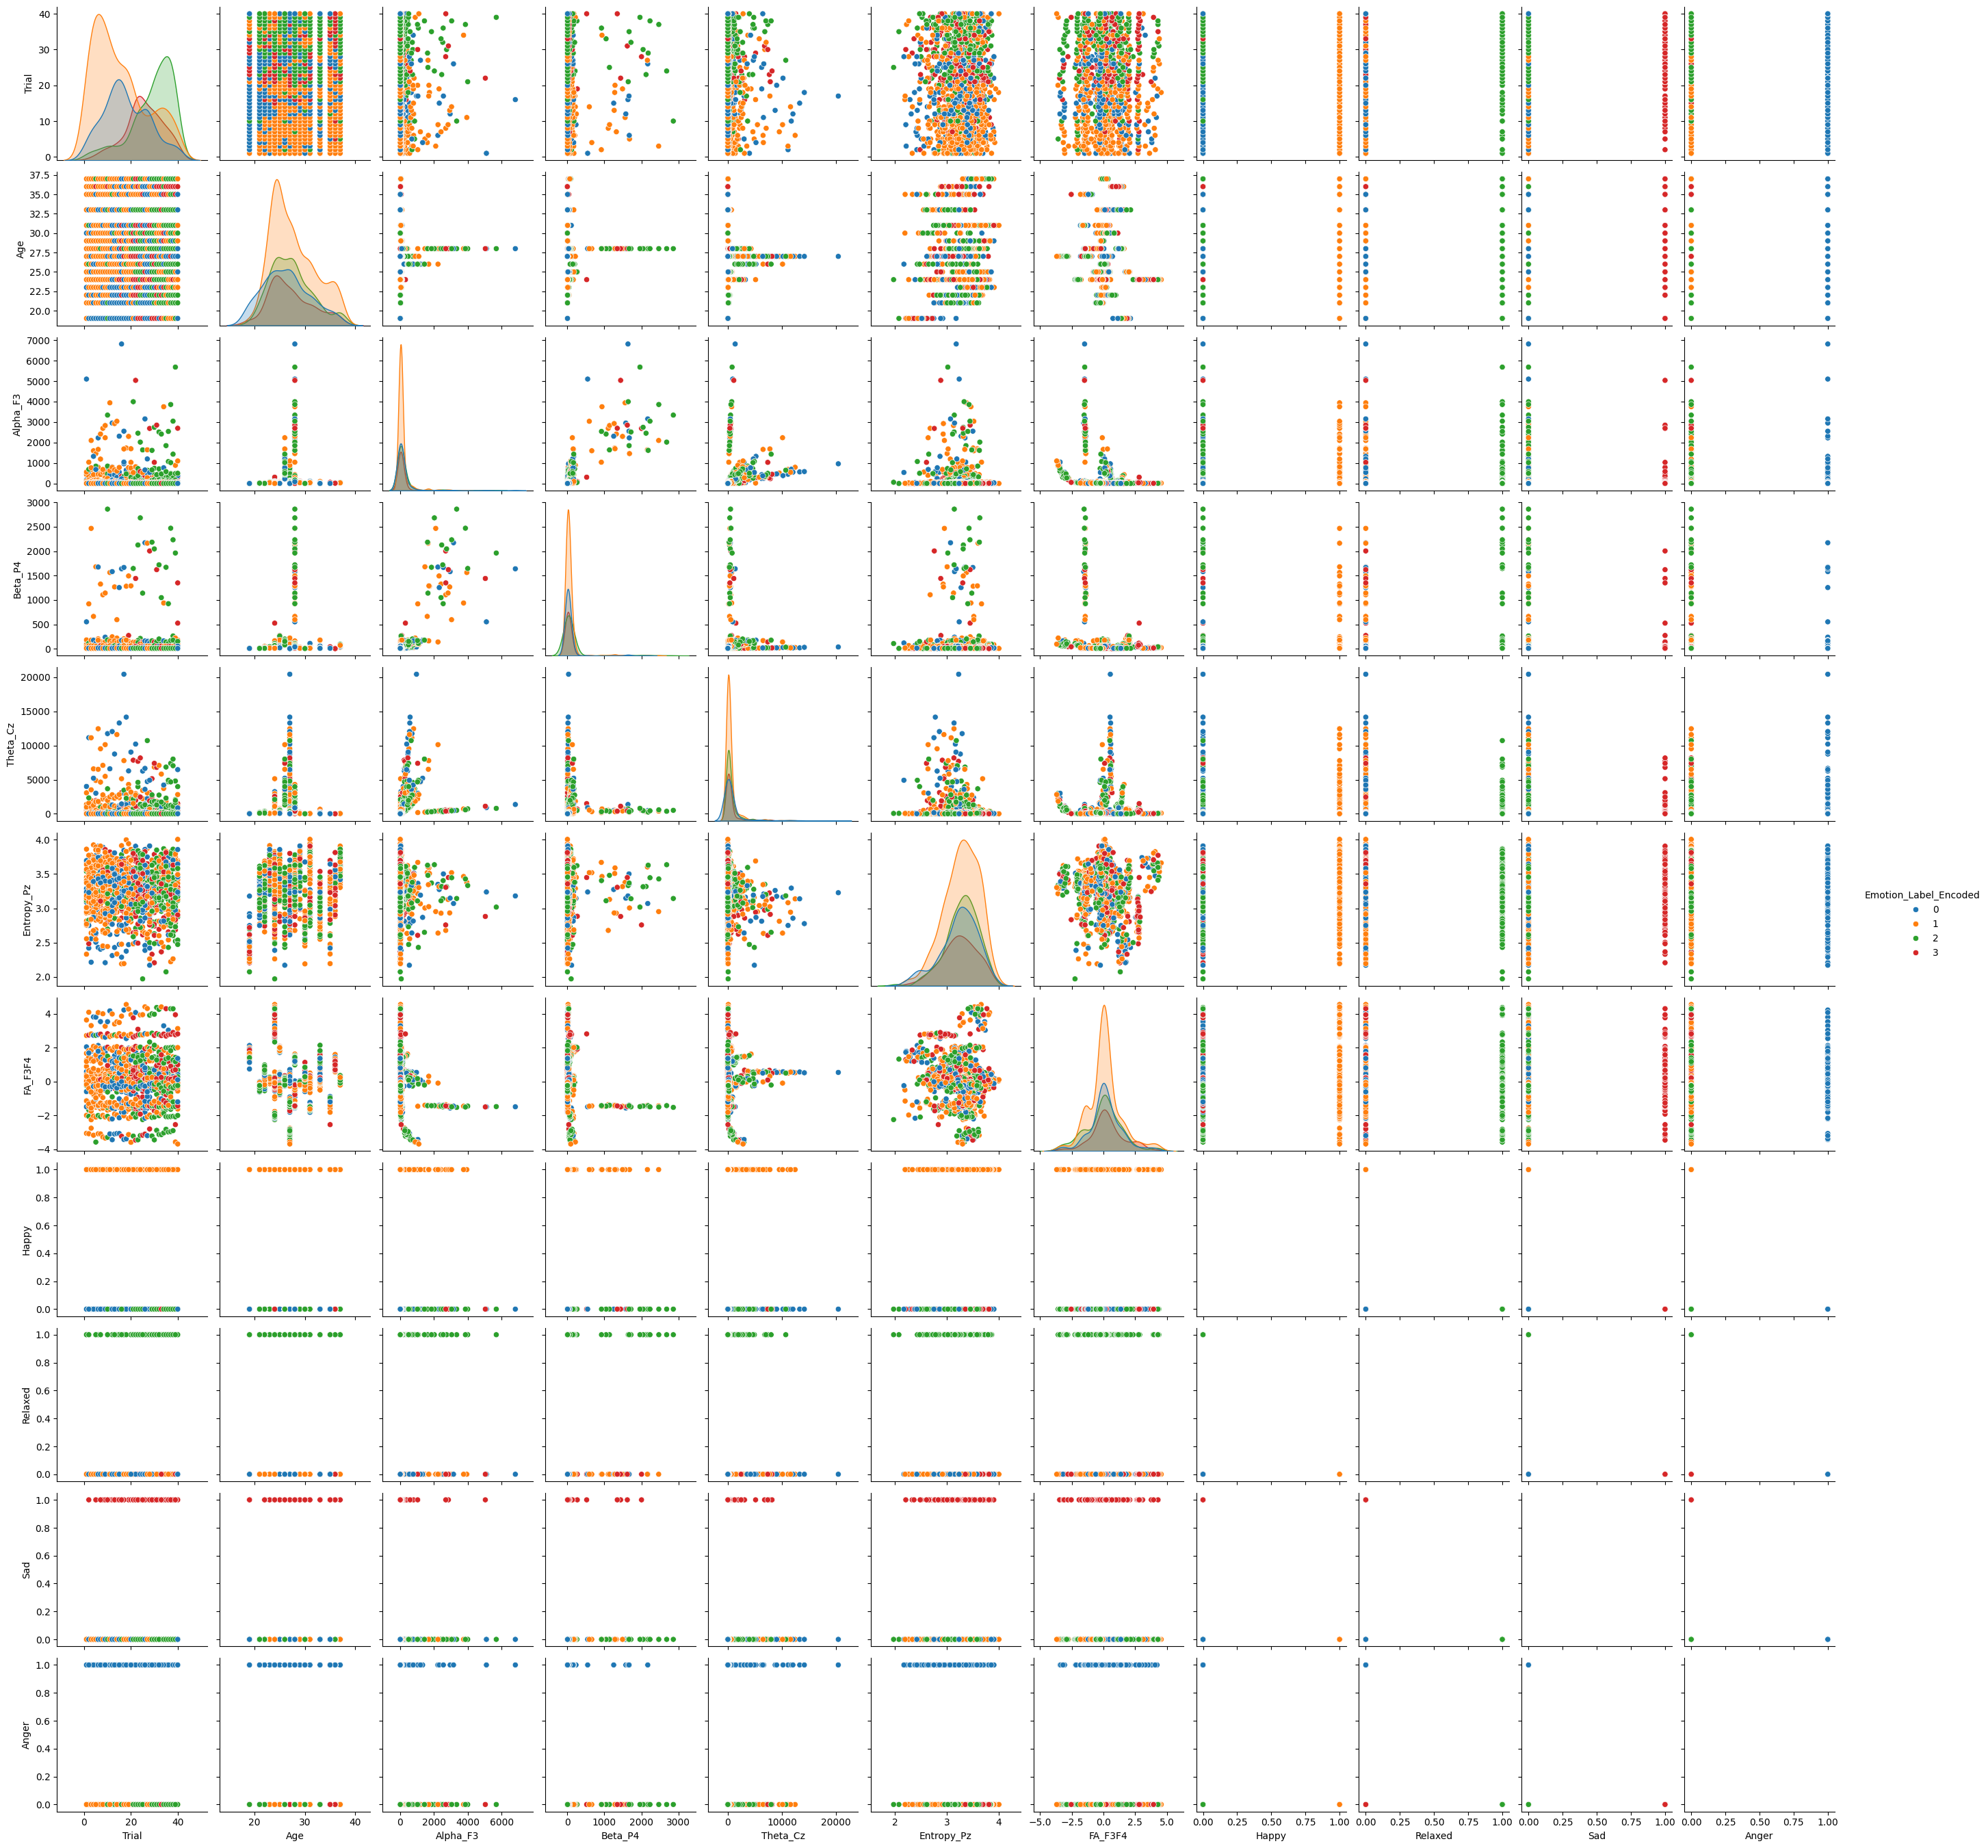

In [9]:

sns.pairplot(df, hue="Emotion_Label_Encoded", palette="tab10")

### Here we will preporcess the data 

In [10]:

# 2. Replace categorical 'Gender' values
gender_mapping = {'Male': 1, 'Female': -1}
df['Gender'] = df['Gender'].map(gender_mapping)

# 3. Define features and target columns
feature_columns = ['Age', 'Gender', 'Alpha_F3', 'Beta_P4', 'Theta_Cz', 'Entropy_Pz',
                   'FA_F3F4', 'Happy', 'Relaxed', 'Sad', 'Anger']
target_column = 'Emotion_Label_Encoded'

# 4. Create feature matrix X and target vector y
X = df[feature_columns]
y = df[target_column]

In [11]:

# 5. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Scale the training and testing feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:

# 7. Apply PCA
n_components = 4
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 8. Scale PCA-transformed data to [-1, 1]
minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_pca_scaled = minmax_scaler.fit_transform(X_train_pca)
X_test_pca_scaled = minmax_scaler.transform(X_test_pca)

# 9. Convert scaled PCA data back to DataFrames for easier handling
# (Note: I'm using X_train_pca_scaled and X_test_pca_scaled from your step 8)
pca_columns = [f'PCA_{i+1}' for i in range(n_components)]


In [13]:

X_train_final = pd.DataFrame(X_train_pca_scaled, columns=pca_columns)
X_test_final = pd.DataFrame(X_test_pca_scaled, columns=pca_columns)

# Also, reset the index for the labels (y) so they align with the new DataFrames
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("--- Final Training Features (X_train_final) ---")
display(X_train_final.head())

print("\n--- Final Training Labels (y_train) ---")
display(y_train.head())

--- Final Training Features (X_train_final) ---


PCA_1     PCA_2     PCA_3     PCA_4
0 -0.884946 -0.129683 -0.678051  0.510793
1 -0.934349  0.249427  0.149719 -0.107981
2 -0.578121 -0.109516 -0.548472  0.676617
3 -0.945701  0.444541  0.030695 -0.003680
4 -0.337998 -0.490824 -0.148336 -0.569400


--- Final Training Labels (y_train) ---


0    0
1    1
2    0
3    1
4    2
Name: Emotion_Label_Encoded, dtype: int64

In [14]:

# Use the V2 Sampler
from qiskit.primitives import StatevectorSampler
# This is the correct V2-compatible kernel class we found
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Scikit-learn Imports
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from qiskit.circuit.library import zz_feature_map  # This is the function

Creating ZZ Feature Map...
Feature map created successfully.


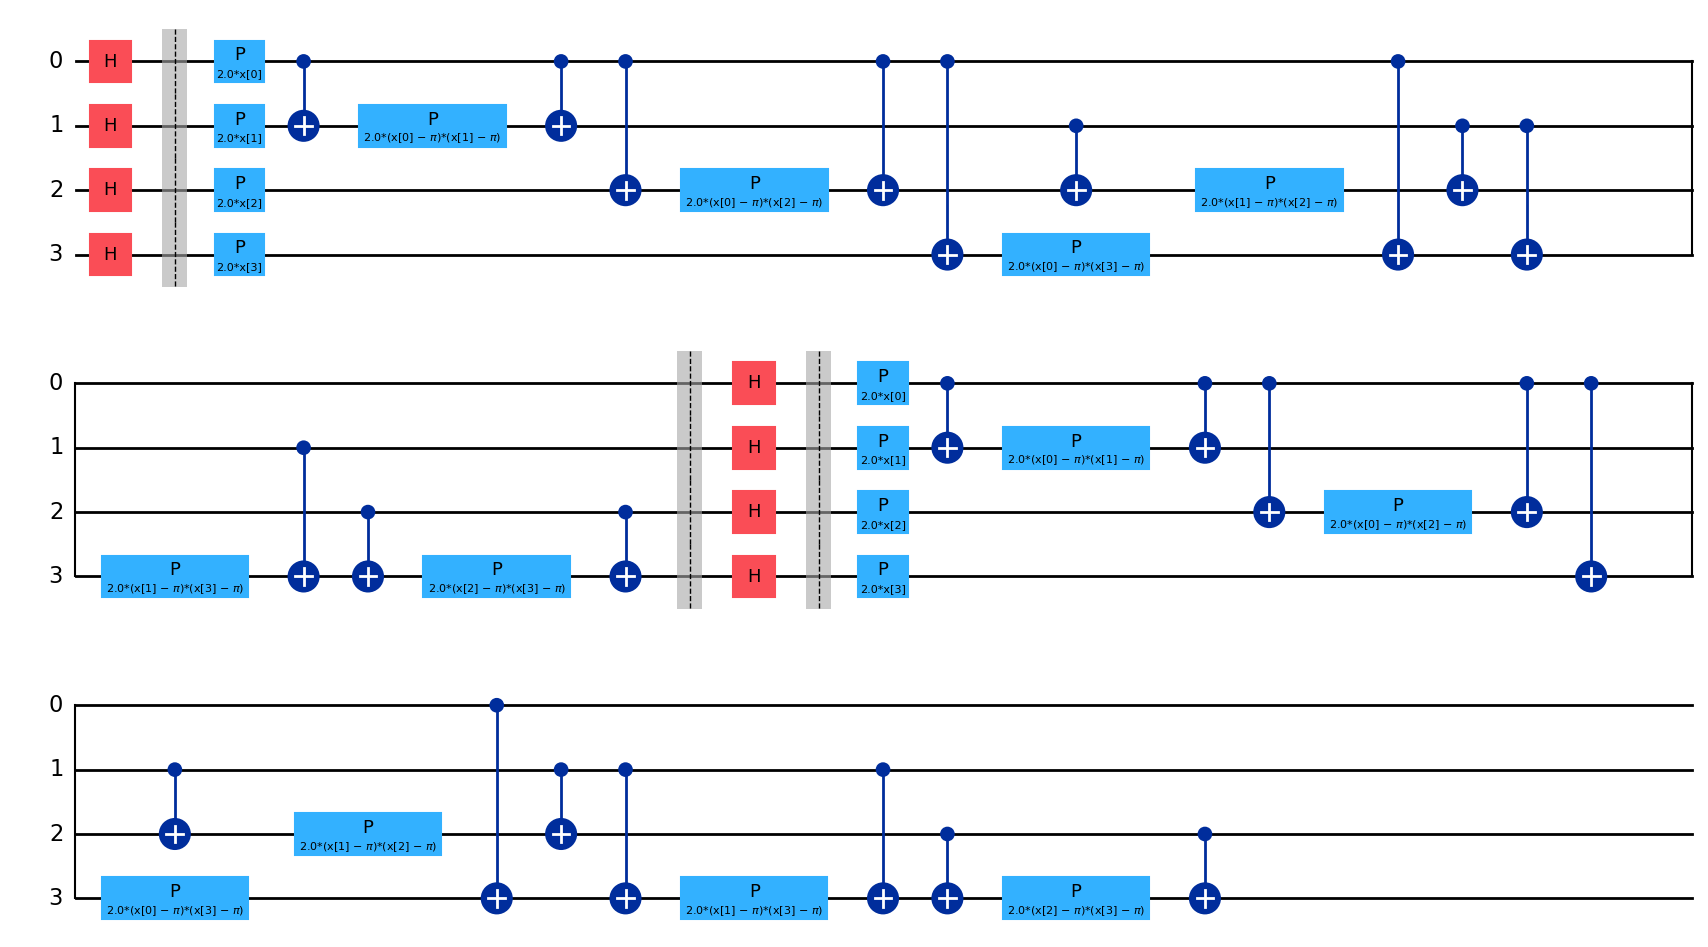

In [15]:

# --- 2. Create your Feature Map Circuit OBJECT ---
print("Creating ZZ Feature Map...")
# We store the circuit in a new variable called 'my_feature_map'
my_feature_map = zz_feature_map(
    feature_dimension=4,  # Your 4 PCA features
    reps=2,
    entanglement='full',
    insert_barriers=True  # <-- THIS IS THE FIX (plural 's')
)
print("Feature map created successfully.")
display(my_feature_map.draw('mpl')) # You can uncomment this to see it

In [16]:



print("--- Quantum SVM Pipeline ---")

# --- 1. Prepare Data for Qiskit & Sklearn ---
# Convert pandas DataFrames/Series to numpy arrays
X_train_numpy = X_train_final.values
y_train_numpy = y_train.values
X_test_numpy = X_test_final.values
y_test_numpy = y_test.values


print(f"Training data shape: {X_train_numpy.shape}")
print(f"Testing data shape:  {X_test_numpy.shape}")


--- Quantum SVM Pipeline ---
Training data shape: (1024, 4)
Testing data shape:  (256, 4)





Qiskit Imports

 --- ASSUMPTIONS ---
 This script assumes you have ALREADY run your data preparation
 and have the following variables in your notebook's memory:

1. X_train_final: (pandas.DataFrame) Your scaled [-1, 1] training features (4 cols)
2. y_train:       (pandas.Series) Your training labels (e.g., 0, 1, 2, 3)
3. X_test_final:  (pandas.DataFrame) Your scaled [-1, 1] testing features (4 cols)
4. y_test:        (pandas.Series) Your testing labels
5. my_feature_map: (QuantumCircuit) Your 4-qubit zz_feature_map circuit object
 ---------------------


Creating Quantum Kernel...
Quantum Kernel created successfully.

Calculating kernel matrices for visualization (this may take a moment)...
Training matrix calculated in 785.72s
Testing matrix calculated in 394.52s
Plotting kernel matrices...


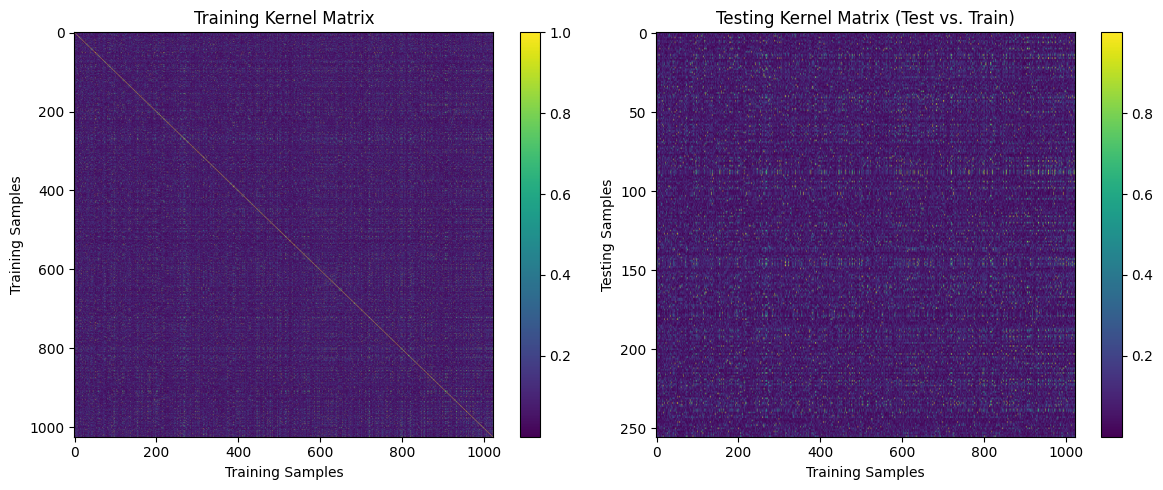

In [17]:


# --- 2. Create the Quantum Kernel ---
# As we discovered, FidelityQuantumKernel does not take a 'sampler' argument.
# It automatically creates a StatevectorSampler internally.
# We just need to pass it the feature map *circuit object*.
try:
    print("\nCreating Quantum Kernel...")
    quantum_kernel = FidelityQuantumKernel(feature_map=my_feature_map)
    print("Quantum Kernel created successfully.")
except NameError as e:
    print("\n--- ERROR ---")
    print("Could not find 'my_feature_map'.")
    print("Please make sure you have run the cell that defines the zz_feature_map and stores it in 'my_feature_map'.")
    print(f"Details: {e}")
    # Stop execution if the map isn't ready
    raise

# --- 3. [User Request] Calculate and Plot Kernel Matrices ---
print("\nCalculating kernel matrices for visualization (this may take a moment)...")

# Calculate the Training Kernel Matrix (Train vs. Train)
t0 = time()
matrix_train = quantum_kernel.evaluate(x_vec=X_train_numpy)
t1 = time()
print(f"Training matrix calculated in {t1-t0:.2f}s")

# Calculate the Testing Kernel Matrix (Test vs. Train)
t0 = time()
matrix_test = quantum_kernel.evaluate(x_vec=X_test_numpy, y_vec=X_train_numpy)
t1 = time()
print(f"Testing matrix calculated in {t1-t0:.2f}s")

# Plot the matrices
print("Plotting kernel matrices...")
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im1 = axs[0].imshow(matrix_train, cmap='viridis', aspect='auto')
axs[0].set_title("Training Kernel Matrix")
axs[0].set_xlabel("Training Samples")
axs[0].set_ylabel("Training Samples")
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(matrix_test, cmap='viridis', aspect='auto')
axs[1].set_title("Testing Kernel Matrix (Test vs. Train)")
axs[1].set_xlabel("Training Samples")
axs[1].set_ylabel("Testing Samples")
fig.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.show()



In [18]:

# --- 4. Create and Train the Quantum SVM ---
# We use the standard scikit-learn SVC
# and pass our quantum_kernel.evaluate function as the "kernel"
qsvc = SVC(kernel=quantum_kernel.evaluate)

print("\nQuantum SVM created. Training...")
print("This is the longest step. It will call the simulator many times.")

t0 = time()
qsvc.fit(X_train_numpy, y_train_numpy)
t1 = time()

print(f"Training complete in {t1-t0:.2f}s!")


Quantum SVM created. Training...
This is the longest step. It will call the simulator many times.
Training complete in 2142.50s!


In [19]:
# --- 5. [User Request] Test Accuracy and Get Predictions ---
print("\nTesting model accuracy...")

# Get predictions for the entire test set
y_pred = qsvc.predict(X_test_numpy)

# Calculate accuracy
test_accuracy = accuracy_score(y_test_numpy, y_pred)
print(f"Quantum SVM Test Accuracy: {test_accuracy * 100:.2f}%")



Testing model accuracy...
Quantum SVM Test Accuracy: 98.05%



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.96      0.97        52
     Class 1       0.99      1.00      1.00       113
     Class 2       0.95      0.98      0.96        54
     Class 3       1.00      0.95      0.97        37

    accuracy                           0.98       256
   macro avg       0.98      0.97      0.98       256
weighted avg       0.98      0.98      0.98       256

Plotting Confusion Matrix...


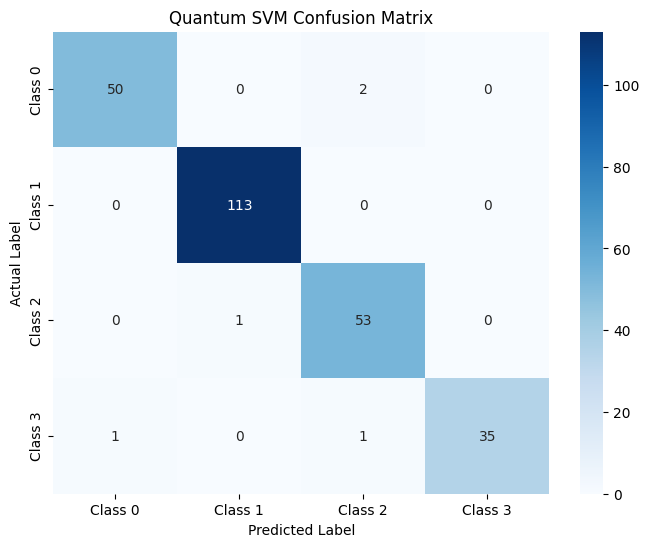


--- Pipeline Finished ---


In [20]:
# --- 6. (Bonus) Classification Report and Confusion Matrix ---
print("\nClassification Report:")
# This gives precision, recall, and f1-score for each class
# You may need to define target_names based on your labels, e.g., ['Happy', 'Relaxed', 'Sad', 'Anger']
class_names = [f"Class {i}" for i in range(len(np.unique(y_train_numpy)))]
print(classification_report(y_test_numpy, y_pred, target_names=class_names))

print("Plotting Confusion Matrix...")
# This shows which classes were confused with others
cm = confusion_matrix(y_test_numpy, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Quantum SVM Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
print("\n--- Pipeline Finished ---")


Calculating kernel matrices for visualization (this may take a moment)...
Training matrix calculated in 797.54s
Testing matrix calculated in 48.24s
Plotting kernel matrices...


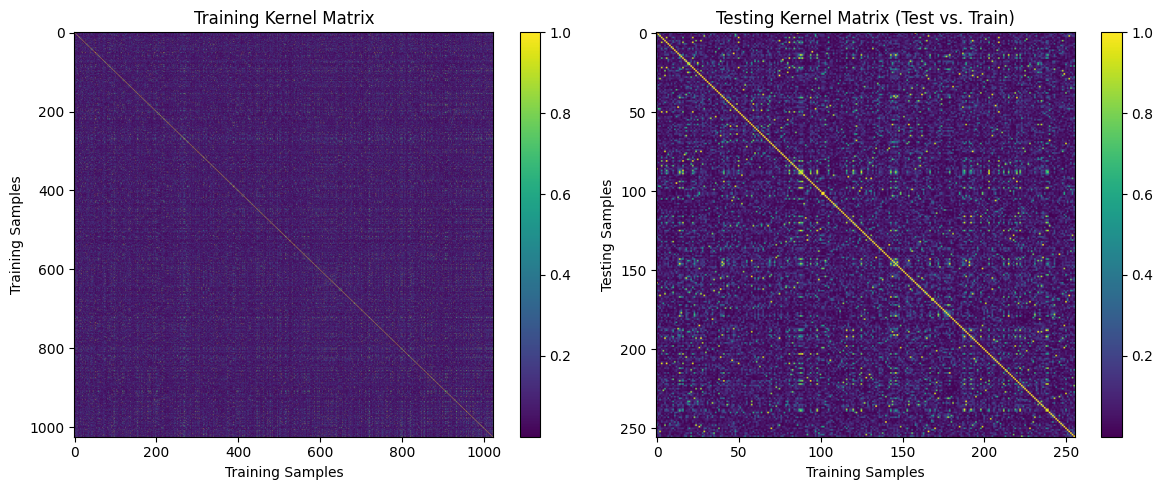

In [22]:

# --- 3. [User Request] Calculate and Plot Kernel Matrices ---
print("\nCalculating kernel matrices for visualization (this may take a moment)...")

# Calculate the Training Kernel Matrix (Train vs. Train)
t0 = time()
matrix_train = quantum_kernel.evaluate(x_vec=X_train_numpy)
t1 = time()
print(f"Training matrix calculated in {t1-t0:.2f}s")

# Calculate the Testing Kernel Matrix (Test vs. Train)
t0 = time()
matrix_test = quantum_kernel.evaluate(x_vec=X_test_numpy)
t1 = time()
print(f"Testing matrix calculated in {t1-t0:.2f}s")

# Plot the matrices
print("Plotting kernel matrices...")
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im1 = axs[0].imshow(matrix_train, cmap='viridis', aspect='auto')
axs[0].set_title("Training Kernel Matrix")
axs[0].set_xlabel("Training Samples")
axs[0].set_ylabel("Training Samples")
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(matrix_test, cmap='viridis', aspect='auto')
axs[1].set_title("Testing Kernel Matrix (Test vs. Train)")
axs[1].set_xlabel("Training Samples")
axs[1].set_ylabel("Testing Samples")
fig.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.show()



#### code similar to 
https://www.kaggle.com/code/muhammadrizkyanugrah/qsvc-eq12-iris-dataset